In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("all_data.csv")



Variables utilisées: ['Heel_Abs', 'Line_C', 'Side_lines', 'Total_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight']


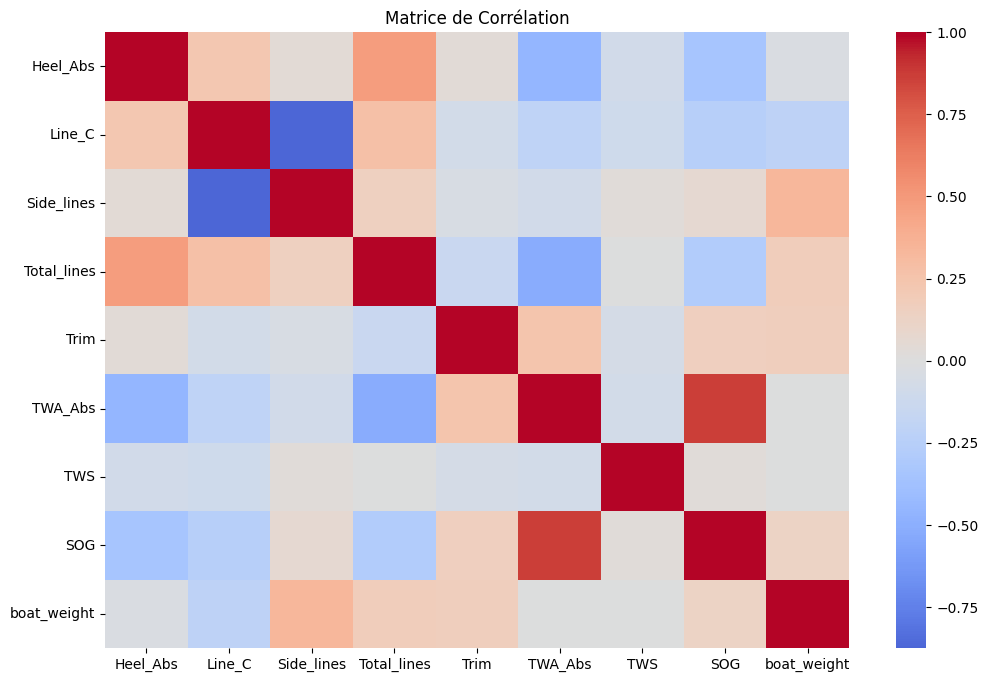

In [2]:
def afficher_matrice_correlation(dataframe, taille_figure=(12, 8), cmap="coolwarm"):
    plt.figure(figsize=taille_figure)
    sns.heatmap(dataframe.corr(), cmap=cmap, center=0)
    plt.title("Matrice de Corrélation")
    plt.show()

df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","ROT"
]
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)
df_numeric.dropna(subset=["SOG"], inplace=True)
print(f"Variables utilisées:", df_numeric.columns.tolist())
afficher_matrice_correlation(df_numeric)

Corrélation avec SOG :
SOG            1.000000
TWA_Abs        0.862650
Trim           0.160931
boat_weight    0.128466
Side_lines     0.065668
TWS            0.031173
Line_C        -0.255391
Total_lines   -0.283058
Heel_Abs      -0.345028
Name: SOG, dtype: float64


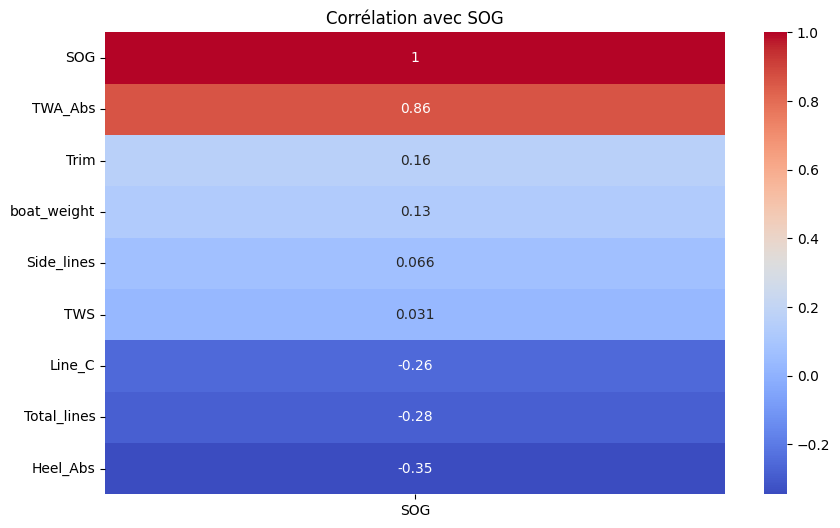

In [3]:
def afficher_correlation_vmg(df, variable="SOG", taille_figure=(10, 6)):
    corr_with_vmg = df.corr()[variable].sort_values(ascending=False)
    print(f"Corrélation avec {variable} :")
    print(corr_with_vmg)
    
    plt.figure(figsize=taille_figure)
    sns.heatmap(corr_with_vmg.to_frame(), annot=True, cmap="coolwarm")
    plt.title(f"Corrélation avec {variable}")
    plt.show()

afficher_correlation_vmg(df_numeric, variable="SOG")

In [ ]:
def calculer_anova_quadratique(df, target="SOG"):
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    cols = df_copy.columns.drop(target)
    
    # Print missing value count before imputation
    print("Missing values before imputation:\n", df_copy[cols].isna().sum())
    """
    # --- 1. ANOVA avec imputation ---
    df_impute = df_copy.copy()
    df_impute[cols] = df_impute[cols].apply(lambda x: x.fillna(x.mean()))
    formula_impute = f"{target} ~ " + " + ".join(
        list(cols) +
        [f"I({col}**2)" for col in cols] +
        [f"I({col}**(1/2))" for col in cols]
    )
    model_impute = smf.ols(formula=formula_impute, data=df_impute).fit()
    anova_impute = sm.stats.anova_lm(model_impute, typ=2)
"""
    # --- 2. ANOVA sans valeurs manquantes ---
    df_no_missing = df_copy.dropna(subset=cols)
    formula_no_missing = f"{target} ~ " + " + ".join(
        list(df_no_missing.columns.drop(target)))
    model_no_missing = smf.ols(formula=formula_no_missing, data=df_no_missing).fit()
    anova_no_missing = sm.stats.anova_lm(model_no_missing, typ=2)
"""
    # --- 3. ANOVA sans les colonnes LineC et SideLines ---
    df_no_linec_sidelines = df_copy.drop(columns=["Line_C", "Side_lines"])
    formula_no_linec_sidelines = f"{target} ~ " + " + ".join(
        list(df_no_linec_sidelines.columns.drop(target)) +
        [f"I({col}**2)" for col in df_no_linec_sidelines.columns.drop(target)] +
        [f"I({col}**(1/2))" for col in df_no_linec_sidelines.columns.drop(target)]
    )
    model_no_linec_sidelines = smf.ols(formula=formula_no_linec_sidelines, data=df_no_linec_sidelines).fit()
    anova_no_linec_sidelines = sm.stats.anova_lm(model_no_linec_sidelines, typ=2)
"""
    return {
        "anova_impute": anova_impute.sort_values("F", ascending=False),
        "anova_no_missing": anova_no_missing.sort_values("F", ascending=False),
        "anova_no_linec_sidelines": anova_no_linec_sidelines.sort_values("F", ascending=False)
    }

resultats_anova = calculer_anova_quadratique(df_numeric)

SyntaxError: invalid syntax (4086266768.py, line 24)

In [ ]:
anova_impute = resultats_anova["anova_impute"]
anova_no_missing = resultats_anova["anova_no_missing"]
anova_no_linec_sidelines = resultats_anova["anova_no_linec_sidelines"]

print("ANOVA avec Imputation:")
display(anova_impute)

print("\nANOVA sans Valeurs Manquantes:")
display(anova_no_missing)

print("\nANOVA sans Line_C et Side_lines:")
display(anova_no_linec_sidelines)

ANOVA avec Imputation:


,sum_sq,df,F,PR(>F)
I(boat_weight ** 2),5105.497881,1.0,4958.832415,0.000000e+00
boat_weight,5090.096420,1.0,4943.873391,0.000000e+00
I(boat_weight ** (1 / 2)),5081.153887,1.0,4935.187750,0.000000e+00
TWA_Abs,3179.682742,1.0,3088.340103,0.000000e+00
I(TWA_Abs ** (1 / 2)),2664.565437,1.0,2588.020555,0.000000e+00
I(TWA_Abs ** 2),2377.686958,1.0,2309.383225,0.000000e+00
I(Side_lines ** (1 / 2)),763.827183,1.0,741.884745,1.335395e-162
Side_lines,549.703360,1.0,533.912050,9.848501e-118
I(Line_C ** 2),468.554110,1.0,455.093972,1.085957e-100
I(Side_lines ** 2),381.631226,1.0,370.668119,2.074717e-82



ANOVA sans Valeurs Manquantes:


,sum_sq,df,F,PR(>F)
I(boat_weight ** 2),6024.577845,1.0,5730.502892,0.000000e+00
boat_weight,6010.905438,1.0,5717.497870,0.000000e+00
I(boat_weight ** (1 / 2)),6002.937760,1.0,5709.919114,0.000000e+00
TWA_Abs,2997.902484,1.0,2851.567246,0.000000e+00
I(TWA_Abs ** (1 / 2)),2562.783253,1.0,2437.687290,0.000000e+00
I(TWA_Abs ** 2),2171.352378,1.0,2065.363151,0.000000e+00
I(Total_lines ** (1 / 2)),159.571762,1.0,151.782659,7.695671e-35
I(TWS ** 2),134.827301,1.0,128.246037,1.053774e-29
TWS,119.543661,1.0,113.708432,1.583616e-26
I(TWS ** (1 / 2)),115.155570,1.0,109.534534,1.295671e-25



ANOVA sans Line_C et Side_lines:


,sum_sq,df,F,PR(>F)
I(boat_weight ** (1 / 2)),5622.395255,1.0,5163.372639,0.000000e+00
boat_weight,5616.749942,1.0,5158.188220,0.000000e+00
I(boat_weight ** 2),5602.161337,1.0,5144.790654,0.000000e+00
TWA_Abs,3512.726015,1.0,3225.940648,0.000000e+00
I(TWA_Abs ** (1 / 2)),3062.517446,1.0,2812.487929,0.000000e+00
I(TWA_Abs ** 2),2543.874881,1.0,2336.188290,0.000000e+00
I(TWS ** 2),203.018816,1.0,186.443989,2.155497e-42
TWS,181.221921,1.0,166.426632,4.937918e-38
I(TWS ** (1 / 2)),175.237361,1.0,160.930663,7.786691e-37
I(Heel_Abs ** 2),112.588881,1.0,103.396919,2.852941e-24


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

def analyser_modele_polynomial_final(df, target="SOG", degree=1, top_coefs=30):
    """
    Version finale qui gère:
    - Les NaN via imputation
    - Les racines carrées sans redondance
    - Les noms de variables clairs
    """
    cols = df.columns.drop(target)
    
    X = df[cols].copy()
    #X_sqrt = X.apply(lambda x: np.sqrt(np.abs(x))).add_prefix('sqrt_')
    # X_combined = pd.concat([X, X_sqrt], axis=1)
    y = df[target].copy()
    
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), 
                           columns=X.columns)
    
    if y.isna().any():
        y = y.fillna(y.mean())

    model = make_pipeline(
        StandardScaler(),
        LinearRegression()
    )

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_imputed)
    feature_names = poly.get_feature_names_out(X.columns)
    
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    print(f"R²: {r2_score(y, y_pred):.3f}")
    print(f"Échantillons utilisés: {len(X_imputed)}")
    
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.named_steps['linearregression'].coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    def is_valid_feature(name):
        if 'sqrt_' in name:
            base_var = name.split('sqrt_')[-1].split(' ')[0].replace('^2','')
            if f'sqrt_{base_var}^2' in name:
                return False  # Élimine sqrt_x^2
        return True
    
    valid_coefs = coef_df[coef_df['feature'].apply(is_valid_feature)].head(top_coefs)
    
    return valid_coefs

resultats = analyser_modele_polynomial_final(df_numeric)
display(resultats)


R²: 0.808
Échantillons utilisés: 80131


,feature,coefficient
5,TWA_Abs,2.422626
3,Total_lines,0.445025
6,TWS,0.256146
7,boat_weight,0.237816
1,Line_C,-0.173471
4,Trim,-0.158170
0,Heel_Abs,0.115322
2,Side_lines,0.045673


## Upwind:

Variables utilisées: ['Heel_Abs', 'Line_C', 'Side_lines', 'Total_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight']


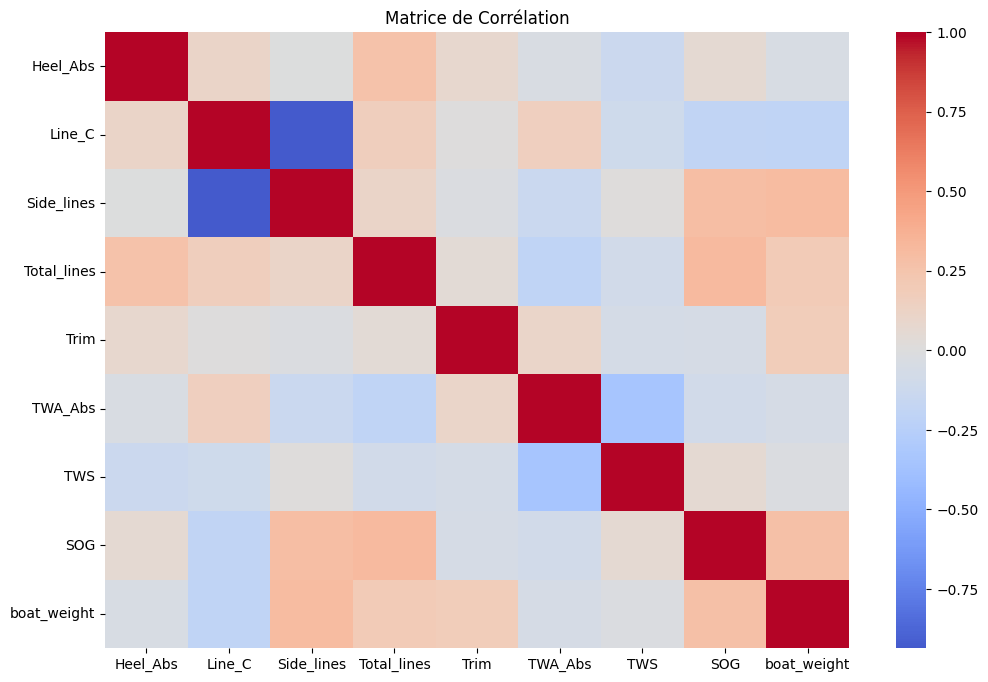

In [ ]:
# Same analysis, but for downwind and upwind separately
upwind_data = df[df['TWA'] >= 0]

# Create a numeric-only version of upwind_data (not df)
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()

"""
drop_cols = [
    "TWA_Abs", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel_Abs", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE"
]
"""
drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","ROT"
]
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Variables utilisées:", df_numeric_upwind.columns.tolist())

afficher_matrice_correlation(df_numeric_upwind)

Corrélation avec SOG :
SOG            1.000000
Total_lines    0.313285
Side_lines     0.289328
boat_weight    0.280603
TWS            0.061336
Heel_Abs       0.056305
Trim          -0.058428
TWA_Abs       -0.089706
Line_C        -0.190149
Name: SOG, dtype: float64


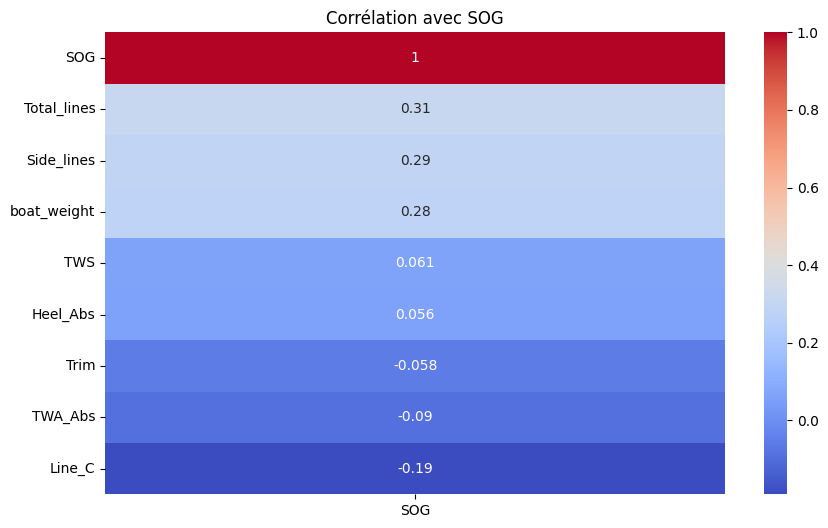

In [ ]:
afficher_correlation_vmg(df_numeric_upwind)

In [ ]:

resultats_anova_upwind = calculer_anova_quadratique(df_numeric_upwind)

anova_impute_upwind = resultats_anova_upwind["anova_impute"]
anova_no_missing_upwind = resultats_anova_upwind["anova_no_missing"]
anova_no_linec_sidelines_upwind = resultats_anova_upwind["anova_no_linec_sidelines"]

print("ANOVA avec Imputation:")
display(anova_impute_upwind)

print("\nANOVA sans Valeurs Manquantes:")
display(anova_no_missing_upwind)

print("\nANOVA sans Line_C et Side_lines:")
display(anova_no_linec_sidelines_upwind)

Missing values before imputation:
 Heel_Abs          0
Line_C          105
Side_lines     5601
Total_lines    5601
Trim              0
TWA_Abs           0
TWS               0
boat_weight       0
dtype: int64
ANOVA avec Imputation:


,sum_sq,df,F,PR(>F)
I(boat_weight ** (1 / 2)),2778.657751,1.0,2840.238187,0.000000e+00
boat_weight,2775.108679,1.0,2836.610460,0.000000e+00
I(boat_weight ** 2),2766.200160,1.0,2827.504511,0.000000e+00
I(Side_lines ** (1 / 2)),206.867008,1.0,211.451582,8.389249e-48
I(Line_C ** 2),129.710595,1.0,132.585233,1.223331e-30
I(TWA_Abs ** (1 / 2)),109.712888,1.0,112.144338,3.552628e-26
TWA_Abs,106.908267,1.0,109.277561,1.503600e-25
I(TWA_Abs ** 2),105.184058,1.0,107.515141,3.651141e-25
Side_lines,103.144761,1.0,105.430648,1.042862e-24
Line_C,75.635846,1.0,77.312083,1.507371e-18



ANOVA sans Valeurs Manquantes:


,sum_sq,df,F,PR(>F)
I(boat_weight ** (1 / 2)),3866.067130,1.0,3825.009466,0.000000e+00
boat_weight,3861.772409,1.0,3820.760354,0.000000e+00
I(boat_weight ** 2),3851.209234,1.0,3810.309360,0.000000e+00
I(TWA_Abs ** (1 / 2)),88.136340,1.0,87.200331,1.027033e-20
TWA_Abs,86.296031,1.0,85.379566,2.574073e-20
I(TWA_Abs ** 2),85.207730,1.0,84.302823,4.432520e-20
I(TWS ** 2),76.913200,1.0,76.096381,2.798573e-18
TWS,54.208480,1.0,53.632785,2.460143e-13
I(Line_C ** 2),50.113313,1.0,49.581109,1.932514e-12
I(TWS ** (1 / 2)),43.803397,1.0,43.338204,4.659106e-11



ANOVA sans Line_C et Side_lines:


,sum_sq,df,F,PR(>F)
I(boat_weight ** (1 / 2)),3780.189433,1.0,3591.148490,0.000000e+00
boat_weight,3768.399682,1.0,3579.948324,0.000000e+00
I(boat_weight ** 2),3742.288534,1.0,3555.142951,0.000000e+00
I(TWS ** 2),134.173554,1.0,127.463759,1.621586e-29
TWS,100.845754,1.0,95.802627,1.341723e-22
I(Total_lines ** (1 / 2)),97.783106,1.0,92.893137,5.815482e-22
I(TWA_Abs ** (1 / 2)),91.220910,1.0,86.659105,1.349409e-20
TWA_Abs,90.767736,1.0,86.228593,1.676843e-20
I(TWA_Abs ** 2),90.486240,1.0,85.961174,1.919117e-20
I(TWS ** (1 / 2)),84.956354,1.0,80.707829,2.722416e-19


In [ ]:
resultats_coefs_upwind = analyser_modele_polynomial_final(df_numeric_upwind)
display(resultats_coefs_upwind.head(5))

R²: 0.202
Échantillons utilisés: 48787


,feature,coefficient
3,Total_lines,0.333112
7,boat_weight,0.231526
1,Line_C,-0.128363
4,Trim,-0.123222
2,Side_lines,0.112529


## Downwind

Variables utilisées: ['Heel_Abs', 'Line_C', 'Side_lines', 'Total_lines', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight']


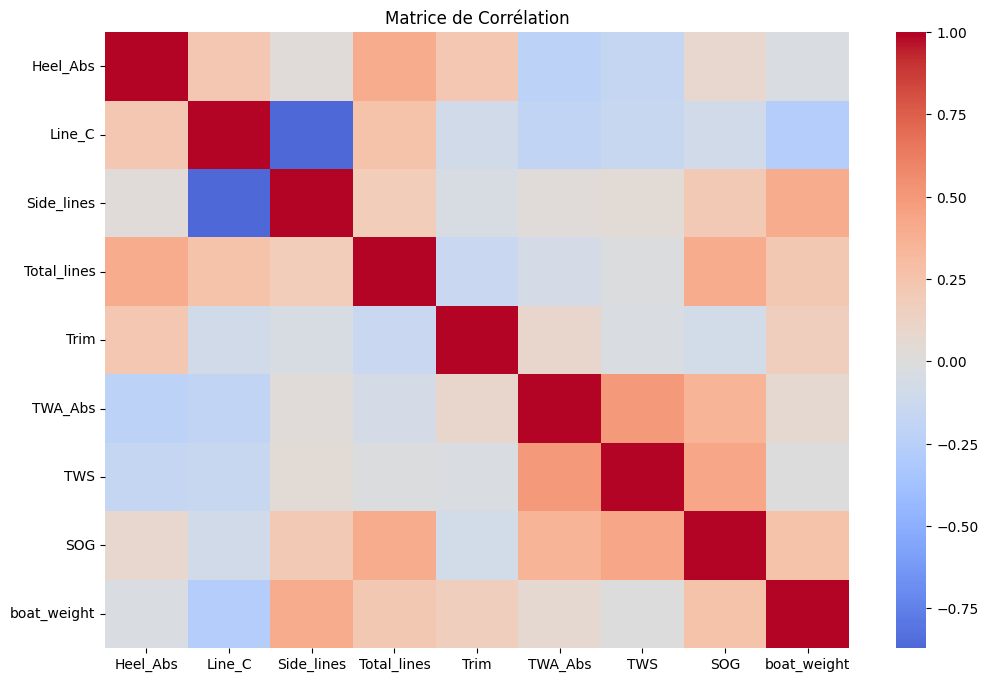

In [ ]:
# Same analysis, but for downwind and upwind separately
downwind_data = df[df['TWA'] <= 0]

# Create a numeric-only version of upwind_data (not df)
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()

"""
drop_cols = [
    "TWA_Abs", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel_Abs", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE"
]
"""
drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg", "ROT"
]
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Variables utilisées:", df_numeric_downwind.columns.tolist())

afficher_matrice_correlation(df_numeric_downwind)

Corrélation avec SOG :
SOG            1.000000
TWS            0.433601
Total_lines    0.406790
TWA_Abs        0.354902
boat_weight    0.255130
Side_lines     0.215051
Heel_Abs       0.085725
Trim          -0.083675
Line_C        -0.095684
Name: SOG, dtype: float64


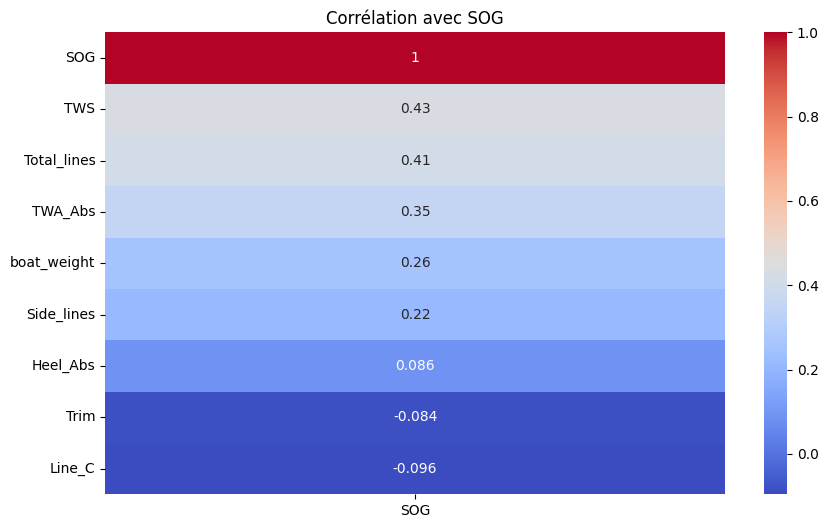

In [ ]:

afficher_correlation_vmg(df_numeric_downwind)

In [ ]:
resultats_anova_downwind = calculer_anova_quadratique(df_numeric_downwind)

anova_impute_downwind = resultats_anova_downwind["anova_impute"]
anova_no_missing_downwind = resultats_anova_downwind["anova_no_missing"]
anova_no_linec_sidelines_downwind = resultats_anova_downwind["anova_no_linec_sidelines"]

print("ANOVA avec Imputation:")
display(anova_impute_downwind)

print("\nANOVA sans Valeurs Manquantes:")
display(anova_no_missing_downwind)

print("\nANOVA sans Line_C et Side_lines:")
display(anova_no_linec_sidelines_downwind)

Missing values before imputation:
 Heel_Abs          0
Line_C          658
Side_lines     3844
Total_lines    3844
Trim              0
TWA_Abs           0
TWS               0
boat_weight       0
dtype: int64
ANOVA avec Imputation:


,sum_sq,df,F,PR(>F)
I(boat_weight ** 2),1519.074078,1.0,1603.994201,0.000000e+00
boat_weight,1505.332681,1.0,1589.484624,0.000000e+00
I(boat_weight ** (1 / 2)),1498.241780,1.0,1581.997324,0.000000e+00
I(TWA_Abs ** (1 / 2)),144.426794,1.0,152.500621,5.954852e-35
TWA_Abs,128.341033,1.0,135.515625,2.959347e-31
I(TWA_Abs ** 2),101.136391,1.0,106.790174,5.435057e-25
I(Heel_Abs ** 2),60.274661,1.0,63.644169,1.541620e-15
Heel_Abs,54.193377,1.0,57.222925,3.999016e-14
I(Total_lines ** 2),46.371151,1.0,48.963417,2.660886e-12
I(Heel_Abs ** (1 / 2)),46.151160,1.0,48.731128,2.994884e-12



ANOVA sans Valeurs Manquantes:


,sum_sq,df,F,PR(>F)
I(boat_weight ** 2),1310.575736,1.0,1349.402171,3.550877e-288
boat_weight,1298.109552,1.0,1336.566671,1.603104e-285
I(boat_weight ** (1 / 2)),1291.744021,1.0,1330.012558,3.638791e-284
I(TWA_Abs ** (1 / 2)),92.392538,1.0,95.129711,1.945225e-22
TWA_Abs,79.602054,1.0,81.960303,1.481472e-19
I(Heel_Abs ** 2),59.628431,1.0,61.394951,4.844556e-15
I(TWA_Abs ** 2),58.701439,1.0,60.440497,7.858261e-15
Heel_Abs,50.775530,1.0,52.279779,4.943533e-13
I(Heel_Abs ** (1 / 2)),42.193423,1.0,43.443423,4.445939e-11
I(Side_lines ** (1 / 2)),16.528227,1.0,17.017883,3.714245e-05



ANOVA sans Line_C et Side_lines:


,sum_sq,df,F,PR(>F)
I(boat_weight ** 2),1355.218827,1.0,1375.157601,1.143710e-293
boat_weight,1348.486033,1.0,1368.325750,2.960820e-292
I(boat_weight ** (1 / 2)),1344.818316,1.0,1364.604071,1.743198e-291
I(TWA_Abs ** (1 / 2)),126.186976,1.0,128.043513,1.279713e-29
TWA_Abs,111.209713,1.0,112.845895,2.627316e-26
I(TWA_Abs ** 2),86.122593,1.0,87.389679,9.575525e-21
I(Heel_Abs ** 2),75.660777,1.0,76.773943,2.026618e-18
Heel_Abs,65.937466,1.0,66.907577,2.968745e-16
I(Heel_Abs ** (1 / 2)),56.129307,1.0,56.955114,4.598721e-14
I(Total_lines ** 2),9.093903,1.0,9.227698,2.386079e-03


In [ ]:
resultats_coefs_downwind = analyser_modele_polynomial_final(df_numeric_downwind)
display(resultats_coefs_downwind.head(30))

R²: 0.420
Échantillons utilisés: 31344


,feature,coefficient
3,Total_lines,0.463014
6,TWS,0.455472
5,TWA_Abs,0.300760
7,boat_weight,0.240092
0,Heel_Abs,0.160406
4,Trim,-0.157425
1,Line_C,-0.138116
2,Side_lines,-0.042531


In [ ]:
import scipy.stats as stats

# Perform a t-test between upwind and downwind data for the "SOG" variable
def t_test_between_upwind_downwind(df_upwind, df_downwind, target="SOG"):
    t_stat, p_value = stats.ttest_ind(df_upwind[target].dropna(), df_downwind[target].dropna())
    print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.3f}")
    
    # If p-value is less than 0.05, the difference is statistically significant
    if p_value < 0.05:
        print("The difference is statistically significant, keeping data split.")
        return True  # Keep data split
    else:
        print("The difference is not statistically significant, keeping data combined.")
        return False  # Keep data combined

# Call the t-test function
split_data = t_test_between_upwind_downwind(df_numeric_upwind, df_numeric_downwind)

# Based on the result of the t-test, split or combine data
if split_data:
    # If the t-test shows a significant difference, keep data split
    # The rest of your code for analysis on `df_numeric_upwind` and `df_numeric_downwind` continues
    print("Proceeding with separate analyses for upwind and downwind data.")
else:
    # If the t-test does not show a significant difference, combine the data
    df_numeric_combined = pd.concat([df_numeric_upwind, df_numeric_downwind], axis=0)
    print("Proceeding with combined analysis.")
    # You can call your existing functions on the combined data
    resultats_anova_combined = calculer_anova_quadratique(df_numeric_combined)
    resultats_coefs_combined = analyser_modele_polynomial_final(df_numeric_combined)
    display(resultats_anova_combined)
    display(resultats_coefs_combined)


T-statistic: -482.303, p-value: 0.000
The difference is statistically significant, keeping data split.
Proceeding with separate analyses for upwind and downwind data.
